In [48]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
import torch.nn as nn

import torch.optim as optim

from utils.constants import *
from utils.generator import Generator
from utils.discriminator import Discriminator

%load_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(str(device))
PATH = "./saved_models"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda


In [49]:
img_paths = []
for path in os.listdir(data_dir + '/monet_'):
    img_paths.append(path)

print("There are {} style images in Monet Paintings Dataset".format(len(img_paths)))

There are 300 style images in Monet Paintings Dataset


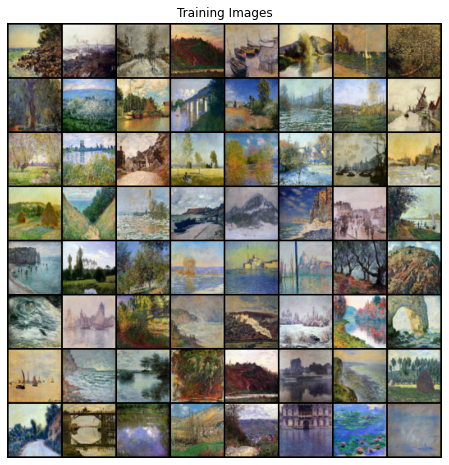

In [50]:
dataset = dset.ImageFolder(root=data_dir,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers, pin_memory=True)

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [51]:
# weight initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [52]:
net_g = Generator(1).to(device)
net_g.apply(weights_init)

print(net_g)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [53]:
net_d = Discriminator(1).to(device)
net_d.apply(weights_init)

print(net_d)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [54]:
if (os.path.exists(f"{PATH}/net_g")):
    net_g.load_state_dict(torch.load(f"{PATH}/net_g"))
if (os.path.exists(f"{PATH}/net_d")):
    net_d.load_state_dict(torch.load(f"{PATH}/net_d"))

In [55]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizer_d = optim.Adam(net_d.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_g = optim.Adam(net_g.parameters(), lr=lr, betas=(beta1, 0.999))

In [56]:
f = open("./losses.txt", "a")
f.write("Losses log for DCGAN\n")

21

In [57]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
print(str(num_epochs))
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        net_d.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = net_d(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = net_g(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = net_d(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizer_d.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        net_g.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = net_d(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizer_g.step()

        # Output training stats
        if i % 50 == 0:
            log_str = ('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            print(log_str)
            f.write(f"{log_str}\n") # write to the log file
            f.flush()

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = net_g(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            torch.save(net_g.state_dict(), f"{PATH}/net_g")
            torch.save(net_d.state_dict(), f"{PATH}/net_d")
        iters += 1
f.close()

Starting Training Loop...
1000
[0/1000][0/3]	Loss_D: 0.5774	Loss_G: 7.3137	D(x): 0.9844	D(G(z)): 0.3571 / 0.0019
[1/1000][0/3]	Loss_D: 0.2428	Loss_G: 5.2765	D(x): 0.9548	D(G(z)): 0.1538 / 0.0108
[2/1000][0/3]	Loss_D: 0.1795	Loss_G: 5.4454	D(x): 0.9504	D(G(z)): 0.1086 / 0.0094
[3/1000][0/3]	Loss_D: 0.2019	Loss_G: 5.7405	D(x): 0.9598	D(G(z)): 0.1336 / 0.0073
[4/1000][0/3]	Loss_D: 0.1979	Loss_G: 6.1451	D(x): 0.9575	D(G(z)): 0.1323 / 0.0035
[5/1000][0/3]	Loss_D: 0.1091	Loss_G: 5.8480	D(x): 0.9537	D(G(z)): 0.0561 / 0.0064
[6/1000][0/3]	Loss_D: 0.2267	Loss_G: 7.8595	D(x): 0.9816	D(G(z)): 0.1666 / 0.0015
[7/1000][0/3]	Loss_D: 0.1416	Loss_G: 6.2109	D(x): 0.9736	D(G(z)): 0.0950 / 0.0058
[8/1000][0/3]	Loss_D: 0.1223	Loss_G: 6.2562	D(x): 0.9705	D(G(z)): 0.0846 / 0.0040
[9/1000][0/3]	Loss_D: 0.0676	Loss_G: 5.7565	D(x): 0.9785	D(G(z)): 0.0437 / 0.0048
[10/1000][0/3]	Loss_D: 0.0871	Loss_G: 5.7065	D(x): 0.9625	D(G(z)): 0.0452 / 0.0072
[11/1000][0/3]	Loss_D: 0.0795	Loss_G: 6.5414	D(x): 0.9810	D(G(z)):

[99/1000][0/3]	Loss_D: 0.1591	Loss_G: 7.1004	D(x): 0.9340	D(G(z)): 0.0734 / 0.0027
[100/1000][0/3]	Loss_D: 0.2493	Loss_G: 8.5189	D(x): 0.9436	D(G(z)): 0.1536 / 0.0008
[101/1000][0/3]	Loss_D: 0.1016	Loss_G: 7.6566	D(x): 0.9560	D(G(z)): 0.0496 / 0.0020
[102/1000][0/3]	Loss_D: 0.1569	Loss_G: 7.1319	D(x): 0.9378	D(G(z)): 0.0771 / 0.0037
[103/1000][0/3]	Loss_D: 0.1784	Loss_G: 8.4175	D(x): 0.9644	D(G(z)): 0.1154 / 0.0009
[104/1000][0/3]	Loss_D: 0.1995	Loss_G: 9.5768	D(x): 0.9692	D(G(z)): 0.1441 / 0.0004
[105/1000][0/3]	Loss_D: 0.3661	Loss_G: 11.4696	D(x): 0.9734	D(G(z)): 0.2468 / 0.0001
[106/1000][0/3]	Loss_D: 0.3466	Loss_G: 10.0163	D(x): 0.9869	D(G(z)): 0.2310 / 0.0004
[107/1000][0/3]	Loss_D: 0.2330	Loss_G: 8.8347	D(x): 0.9625	D(G(z)): 0.1471 / 0.0008
[108/1000][0/3]	Loss_D: 0.1787	Loss_G: 8.2287	D(x): 0.9649	D(G(z)): 0.1188 / 0.0009
[109/1000][0/3]	Loss_D: 0.3337	Loss_G: 8.9773	D(x): 0.7582	D(G(z)): 0.0024 / 0.0044
[110/1000][0/3]	Loss_D: 0.2117	Loss_G: 7.0002	D(x): 0.8904	D(G(z)): 0.0592 

[197/1000][0/3]	Loss_D: 0.4667	Loss_G: 7.6020	D(x): 0.8905	D(G(z)): 0.2232 / 0.0012
[198/1000][0/3]	Loss_D: 0.2179	Loss_G: 7.5668	D(x): 0.9654	D(G(z)): 0.1504 / 0.0020
[199/1000][0/3]	Loss_D: 0.1766	Loss_G: 5.7543	D(x): 0.9533	D(G(z)): 0.1062 / 0.0061
[200/1000][0/3]	Loss_D: 0.2038	Loss_G: 5.4651	D(x): 0.9142	D(G(z)): 0.0925 / 0.0089
[201/1000][0/3]	Loss_D: 0.1844	Loss_G: 6.0002	D(x): 0.9247	D(G(z)): 0.0856 / 0.0042
[202/1000][0/3]	Loss_D: 0.3425	Loss_G: 6.6818	D(x): 0.7778	D(G(z)): 0.0076 / 0.0039
[203/1000][0/3]	Loss_D: 0.3929	Loss_G: 5.1204	D(x): 0.7456	D(G(z)): 0.0114 / 0.0170
[204/1000][0/3]	Loss_D: 0.1750	Loss_G: 7.1580	D(x): 0.9759	D(G(z)): 0.1162 / 0.0033
[205/1000][0/3]	Loss_D: 0.3704	Loss_G: 5.3865	D(x): 0.7853	D(G(z)): 0.0069 / 0.0091
[206/1000][0/3]	Loss_D: 0.2336	Loss_G: 7.3742	D(x): 0.9369	D(G(z)): 0.1313 / 0.0018
[207/1000][0/3]	Loss_D: 0.1258	Loss_G: 7.3167	D(x): 0.9477	D(G(z)): 0.0640 / 0.0014
[208/1000][0/3]	Loss_D: 0.1072	Loss_G: 6.2609	D(x): 0.9241	D(G(z)): 0.0216 /

[295/1000][0/3]	Loss_D: 0.0274	Loss_G: 6.1164	D(x): 0.9813	D(G(z)): 0.0082 / 0.0047
[296/1000][0/3]	Loss_D: 0.0316	Loss_G: 6.1360	D(x): 0.9834	D(G(z)): 0.0145 / 0.0045
[297/1000][0/3]	Loss_D: 0.0295	Loss_G: 5.8964	D(x): 0.9894	D(G(z)): 0.0184 / 0.0048
[298/1000][0/3]	Loss_D: 0.0301	Loss_G: 5.6978	D(x): 0.9834	D(G(z)): 0.0130 / 0.0063
[299/1000][0/3]	Loss_D: 0.0370	Loss_G: 6.3385	D(x): 0.9730	D(G(z)): 0.0090 / 0.0047
[300/1000][0/3]	Loss_D: 0.0442	Loss_G: 6.5924	D(x): 0.9801	D(G(z)): 0.0219 / 0.0040
[301/1000][0/3]	Loss_D: 0.0397	Loss_G: 5.9631	D(x): 0.9890	D(G(z)): 0.0276 / 0.0049
[302/1000][0/3]	Loss_D: 0.0314	Loss_G: 5.6852	D(x): 0.9834	D(G(z)): 0.0143 / 0.0058
[303/1000][0/3]	Loss_D: 0.0551	Loss_G: 6.3015	D(x): 0.9842	D(G(z)): 0.0362 / 0.0046
[304/1000][0/3]	Loss_D: 0.0286	Loss_G: 5.7436	D(x): 0.9867	D(G(z)): 0.0148 / 0.0070
[305/1000][0/3]	Loss_D: 0.0366	Loss_G: 5.9409	D(x): 0.9876	D(G(z)): 0.0226 / 0.0061
[306/1000][0/3]	Loss_D: 0.0274	Loss_G: 5.9756	D(x): 0.9825	D(G(z)): 0.0096 /

[393/1000][0/3]	Loss_D: 0.0204	Loss_G: 5.9669	D(x): 0.9916	D(G(z)): 0.0117 / 0.0056
[394/1000][0/3]	Loss_D: 0.0219	Loss_G: 5.9497	D(x): 0.9943	D(G(z)): 0.0157 / 0.0054
[395/1000][0/3]	Loss_D: 0.0169	Loss_G: 6.0908	D(x): 0.9921	D(G(z)): 0.0088 / 0.0045
[396/1000][0/3]	Loss_D: 0.0202	Loss_G: 5.9744	D(x): 0.9924	D(G(z)): 0.0123 / 0.0050
[397/1000][0/3]	Loss_D: 0.0166	Loss_G: 5.9651	D(x): 0.9925	D(G(z)): 0.0089 / 0.0049
[398/1000][0/3]	Loss_D: 0.0246	Loss_G: 5.8260	D(x): 0.9942	D(G(z)): 0.0183 / 0.0060
[399/1000][0/3]	Loss_D: 0.0185	Loss_G: 5.9526	D(x): 0.9927	D(G(z)): 0.0109 / 0.0063
[400/1000][0/3]	Loss_D: 0.0194	Loss_G: 6.0277	D(x): 0.9891	D(G(z)): 0.0083 / 0.0051
[401/1000][0/3]	Loss_D: 0.0200	Loss_G: 5.8983	D(x): 0.9897	D(G(z)): 0.0095 / 0.0052
[402/1000][0/3]	Loss_D: 0.0186	Loss_G: 5.9353	D(x): 0.9919	D(G(z)): 0.0103 / 0.0048
[403/1000][0/3]	Loss_D: 0.0180	Loss_G: 5.9752	D(x): 0.9919	D(G(z)): 0.0097 / 0.0053
[404/1000][0/3]	Loss_D: 0.0177	Loss_G: 5.9294	D(x): 0.9923	D(G(z)): 0.0099 /

[491/1000][0/3]	Loss_D: 0.0172	Loss_G: 6.0818	D(x): 0.9875	D(G(z)): 0.0045 / 0.0043
[492/1000][0/3]	Loss_D: 0.0138	Loss_G: 5.9359	D(x): 0.9943	D(G(z)): 0.0080 / 0.0053
[493/1000][0/3]	Loss_D: 0.0147	Loss_G: 5.8187	D(x): 0.9931	D(G(z)): 0.0077 / 0.0057
[494/1000][0/3]	Loss_D: 0.0127	Loss_G: 6.1429	D(x): 0.9933	D(G(z)): 0.0060 / 0.0042
[495/1000][0/3]	Loss_D: 0.0160	Loss_G: 5.7519	D(x): 0.9943	D(G(z)): 0.0101 / 0.0059
[496/1000][0/3]	Loss_D: 0.0123	Loss_G: 5.9077	D(x): 0.9936	D(G(z)): 0.0058 / 0.0049
[497/1000][0/3]	Loss_D: 0.0157	Loss_G: 5.7774	D(x): 0.9930	D(G(z)): 0.0086 / 0.0059
[498/1000][0/3]	Loss_D: 0.0133	Loss_G: 6.0649	D(x): 0.9926	D(G(z)): 0.0058 / 0.0048
[499/1000][0/3]	Loss_D: 0.0144	Loss_G: 5.9797	D(x): 0.9950	D(G(z)): 0.0093 / 0.0051
[500/1000][0/3]	Loss_D: 0.0145	Loss_G: 5.5973	D(x): 0.9946	D(G(z)): 0.0090 / 0.0061
[501/1000][0/3]	Loss_D: 0.0129	Loss_G: 5.8279	D(x): 0.9940	D(G(z)): 0.0068 / 0.0051
[502/1000][0/3]	Loss_D: 0.0133	Loss_G: 5.8364	D(x): 0.9920	D(G(z)): 0.0053 /

[589/1000][0/3]	Loss_D: 0.0107	Loss_G: 6.1060	D(x): 0.9949	D(G(z)): 0.0055 / 0.0043
[590/1000][0/3]	Loss_D: 0.0087	Loss_G: 5.7938	D(x): 0.9972	D(G(z)): 0.0058 / 0.0050
[591/1000][0/3]	Loss_D: 0.0092	Loss_G: 6.2720	D(x): 0.9946	D(G(z)): 0.0038 / 0.0035
[592/1000][0/3]	Loss_D: 0.0129	Loss_G: 5.9113	D(x): 0.9958	D(G(z)): 0.0085 / 0.0047
[593/1000][0/3]	Loss_D: 0.0101	Loss_G: 5.6862	D(x): 0.9965	D(G(z)): 0.0066 / 0.0050
[594/1000][0/3]	Loss_D: 0.0102	Loss_G: 6.0192	D(x): 0.9967	D(G(z)): 0.0069 / 0.0044
[595/1000][0/3]	Loss_D: 0.0099	Loss_G: 6.3451	D(x): 0.9952	D(G(z)): 0.0050 / 0.0035
[596/1000][0/3]	Loss_D: 0.0129	Loss_G: 5.7957	D(x): 0.9971	D(G(z)): 0.0099 / 0.0050
[597/1000][0/3]	Loss_D: 0.0110	Loss_G: 5.7366	D(x): 0.9962	D(G(z)): 0.0072 / 0.0056
[598/1000][0/3]	Loss_D: 0.0123	Loss_G: 6.0274	D(x): 0.9915	D(G(z)): 0.0037 / 0.0042
[599/1000][0/3]	Loss_D: 0.0090	Loss_G: 5.9503	D(x): 0.9967	D(G(z)): 0.0056 / 0.0042
[600/1000][0/3]	Loss_D: 0.0089	Loss_G: 5.6981	D(x): 0.9970	D(G(z)): 0.0059 /

[687/1000][0/3]	Loss_D: 0.0077	Loss_G: 5.9346	D(x): 0.9978	D(G(z)): 0.0055 / 0.0043
[688/1000][0/3]	Loss_D: 0.0084	Loss_G: 6.2114	D(x): 0.9955	D(G(z)): 0.0039 / 0.0034
[689/1000][0/3]	Loss_D: 0.0082	Loss_G: 6.2464	D(x): 0.9957	D(G(z)): 0.0039 / 0.0033
[690/1000][0/3]	Loss_D: 0.0066	Loss_G: 6.3521	D(x): 0.9967	D(G(z)): 0.0032 / 0.0028
[691/1000][0/3]	Loss_D: 0.0077	Loss_G: 6.1204	D(x): 0.9972	D(G(z)): 0.0049 / 0.0035
[692/1000][0/3]	Loss_D: 0.0061	Loss_G: 6.3602	D(x): 0.9970	D(G(z)): 0.0030 / 0.0027
[693/1000][0/3]	Loss_D: 0.0070	Loss_G: 6.2440	D(x): 0.9979	D(G(z)): 0.0049 / 0.0037
[694/1000][0/3]	Loss_D: 0.0080	Loss_G: 6.3044	D(x): 0.9965	D(G(z)): 0.0045 / 0.0033
[695/1000][0/3]	Loss_D: 0.0074	Loss_G: 5.9936	D(x): 0.9971	D(G(z)): 0.0045 / 0.0038
[696/1000][0/3]	Loss_D: 0.0075	Loss_G: 6.4012	D(x): 0.9955	D(G(z)): 0.0030 / 0.0029
[697/1000][0/3]	Loss_D: 0.0065	Loss_G: 6.3507	D(x): 0.9972	D(G(z)): 0.0037 / 0.0031
[698/1000][0/3]	Loss_D: 0.0071	Loss_G: 6.2636	D(x): 0.9968	D(G(z)): 0.0038 /

[785/1000][0/3]	Loss_D: 1.2627	Loss_G: 2.9556	D(x): 0.6823	D(G(z)): 0.4546 / 0.0977
[786/1000][0/3]	Loss_D: 1.7654	Loss_G: 1.4514	D(x): 0.3923	D(G(z)): 0.1991 / 0.3071
[787/1000][0/3]	Loss_D: 1.4190	Loss_G: 3.5326	D(x): 0.8485	D(G(z)): 0.6270 / 0.0719
[788/1000][0/3]	Loss_D: 1.0906	Loss_G: 3.5960	D(x): 0.7710	D(G(z)): 0.4337 / 0.0611
[789/1000][0/3]	Loss_D: 0.8026	Loss_G: 3.0475	D(x): 0.6680	D(G(z)): 0.2366 / 0.0886
[790/1000][0/3]	Loss_D: 1.0286	Loss_G: 2.4077	D(x): 0.5736	D(G(z)): 0.2316 / 0.1554
[791/1000][0/3]	Loss_D: 1.2508	Loss_G: 4.1538	D(x): 0.7299	D(G(z)): 0.5024 / 0.0558
[792/1000][0/3]	Loss_D: 1.2224	Loss_G: 3.1477	D(x): 0.6006	D(G(z)): 0.4086 / 0.0716
[793/1000][0/3]	Loss_D: 0.9912	Loss_G: 2.6913	D(x): 0.5812	D(G(z)): 0.2154 / 0.1112
[794/1000][0/3]	Loss_D: 1.0158	Loss_G: 5.1409	D(x): 0.8199	D(G(z)): 0.4718 / 0.0136
[795/1000][0/3]	Loss_D: 1.1100	Loss_G: 3.3649	D(x): 0.4762	D(G(z)): 0.0465 / 0.0884
[796/1000][0/3]	Loss_D: 1.5962	Loss_G: 3.9414	D(x): 0.4681	D(G(z)): 0.3706 /

[883/1000][0/3]	Loss_D: 0.4322	Loss_G: 15.3966	D(x): 0.9876	D(G(z)): 0.2779 / 0.0000
[884/1000][0/3]	Loss_D: 0.0635	Loss_G: 7.4053	D(x): 0.9846	D(G(z)): 0.0373 / 0.0056
[885/1000][0/3]	Loss_D: 0.0956	Loss_G: 6.8007	D(x): 0.9359	D(G(z)): 0.0198 / 0.0095
[886/1000][0/3]	Loss_D: 0.1218	Loss_G: 7.3880	D(x): 0.9598	D(G(z)): 0.0670 / 0.0024
[887/1000][0/3]	Loss_D: 0.0590	Loss_G: 8.0551	D(x): 0.9686	D(G(z)): 0.0245 / 0.0030
[888/1000][0/3]	Loss_D: 0.0690	Loss_G: 7.8059	D(x): 0.9507	D(G(z)): 0.0160 / 0.0015
[889/1000][0/3]	Loss_D: 0.1624	Loss_G: 10.0146	D(x): 0.9825	D(G(z)): 0.1190 / 0.0005
[890/1000][0/3]	Loss_D: 0.1978	Loss_G: 10.0834	D(x): 0.9819	D(G(z)): 0.1436 / 0.0004
[891/1000][0/3]	Loss_D: 0.1321	Loss_G: 8.2876	D(x): 0.9732	D(G(z)): 0.0877 / 0.0011
[892/1000][0/3]	Loss_D: 0.0910	Loss_G: 7.4274	D(x): 0.9628	D(G(z)): 0.0459 / 0.0021
[893/1000][0/3]	Loss_D: 0.0918	Loss_G: 7.0180	D(x): 0.9682	D(G(z)): 0.0539 / 0.0025
[894/1000][0/3]	Loss_D: 0.0577	Loss_G: 6.4252	D(x): 0.9705	D(G(z)): 0.025

[981/1000][0/3]	Loss_D: 0.0235	Loss_G: 5.9404	D(x): 0.9856	D(G(z)): 0.0085 / 0.0058
[982/1000][0/3]	Loss_D: 0.0292	Loss_G: 5.4606	D(x): 0.9906	D(G(z)): 0.0193 / 0.0074
[983/1000][0/3]	Loss_D: 0.0274	Loss_G: 5.7162	D(x): 0.9842	D(G(z)): 0.0112 / 0.0079
[984/1000][0/3]	Loss_D: 0.0280	Loss_G: 5.3811	D(x): 0.9880	D(G(z)): 0.0155 / 0.0079
[985/1000][0/3]	Loss_D: 0.0309	Loss_G: 5.5783	D(x): 0.9877	D(G(z)): 0.0176 / 0.0069
[986/1000][0/3]	Loss_D: 0.0205	Loss_G: 5.5248	D(x): 0.9915	D(G(z)): 0.0117 / 0.0071
[987/1000][0/3]	Loss_D: 0.0200	Loss_G: 5.6428	D(x): 0.9901	D(G(z)): 0.0099 / 0.0062
[988/1000][0/3]	Loss_D: 0.0264	Loss_G: 5.5993	D(x): 0.9930	D(G(z)): 0.0187 / 0.0075
[989/1000][0/3]	Loss_D: 0.0199	Loss_G: 5.5489	D(x): 0.9923	D(G(z)): 0.0120 / 0.0070
[990/1000][0/3]	Loss_D: 0.0268	Loss_G: 5.5526	D(x): 0.9916	D(G(z)): 0.0178 / 0.0076
[991/1000][0/3]	Loss_D: 0.0211	Loss_G: 5.4408	D(x): 0.9921	D(G(z)): 0.0129 / 0.0074
[992/1000][0/3]	Loss_D: 0.0290	Loss_G: 5.2996	D(x): 0.9902	D(G(z)): 0.0187 /

In [58]:
torch.save(net_g.state_dict(), f"{PATH}/net_g")
torch.save(net_d.state_dict(), f"{PATH}/net_d")

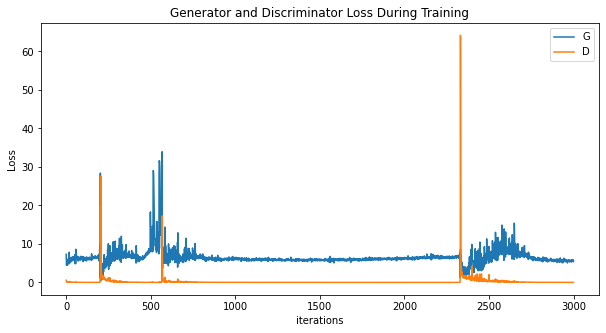

In [59]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

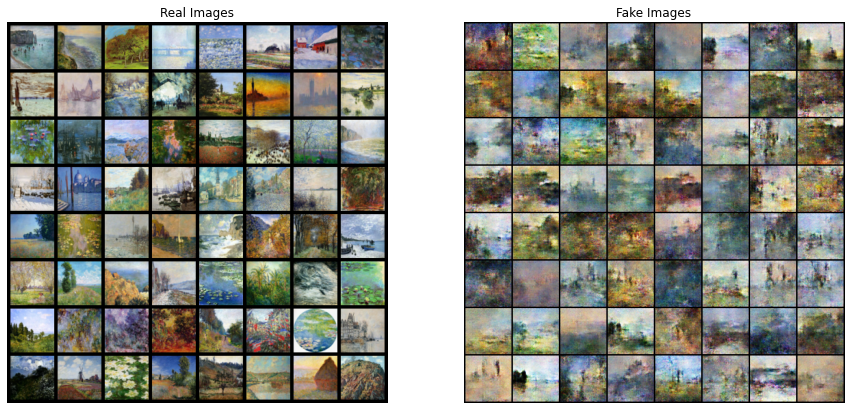

In [60]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()